# Genetic Algorithm Optimization

## Introduction

Genetic Algorithms (GAs) are metaheuristic optimization techniques inspired by the process of natural selection. They belong to the broader class of evolutionary algorithms and are particularly effective for solving complex optimization problems where traditional gradient-based methods fail.

## Theoretical Foundation

### Biological Inspiration

GAs mimic Darwinian evolution through the following mechanisms:
- **Selection**: Fitter individuals have higher probability of reproduction
- **Crossover (Recombination)**: Genetic material is exchanged between parents
- **Mutation**: Random alterations introduce genetic diversity

### Mathematical Framework

Consider an optimization problem:

$$\min_{\mathbf{x} \in \mathcal{S}} f(\mathbf{x})$$

where $\mathbf{x} = (x_1, x_2, \ldots, x_n)$ is a candidate solution in search space $\mathcal{S}$, and $f: \mathcal{S} \rightarrow \mathbb{R}$ is the objective (fitness) function.

### Population Representation

A population $P_t$ at generation $t$ consists of $N$ individuals:

$$P_t = \{\mathbf{x}_1^{(t)}, \mathbf{x}_2^{(t)}, \ldots, \mathbf{x}_N^{(t)}\}$$

### Selection Probability

For fitness-proportionate (roulette wheel) selection, the probability of selecting individual $i$ is:

$$p_i = \frac{f_i}{\sum_{j=1}^{N} f_j}$$

For tournament selection with tournament size $k$, we select the best individual from $k$ randomly chosen candidates.

### Crossover Operators

**Single-point crossover** at position $c$:

$$\mathbf{x}_{\text{child}} = (x_1^{(a)}, \ldots, x_c^{(a)}, x_{c+1}^{(b)}, \ldots, x_n^{(b)})$$

**Arithmetic crossover** with parameter $\alpha \in [0, 1]$:

$$\mathbf{x}_{\text{child}} = \alpha \mathbf{x}^{(a)} + (1 - \alpha) \mathbf{x}^{(b)}$$

### Mutation

For real-valued encoding, Gaussian mutation adds noise:

$$x_i' = x_i + \mathcal{N}(0, \sigma^2)$$

where $\sigma$ is the mutation strength parameter.

### Convergence

The schema theorem provides theoretical grounding. A schema $H$ with order $o(H)$ and defining length $\delta(H)$ has expected growth:

$$E[m(H, t+1)] \geq m(H, t) \cdot \frac{f(H)}{\bar{f}} \cdot \left[1 - p_c \frac{\delta(H)}{L-1}\right] \cdot (1 - p_m)^{o(H)}$$

where $m(H, t)$ is the number of instances of schema $H$ at time $t$, $f(H)$ is the average fitness of individuals matching $H$, and $\bar{f}$ is the population average fitness.

## Implementation

We will implement a GA to optimize the **Rastrigin function**, a classic benchmark for optimization algorithms:

$$f(\mathbf{x}) = An + \sum_{i=1}^{n} \left[x_i^2 - A\cos(2\pi x_i)\right]$$

where $A = 10$ and $x_i \in [-5.12, 5.12]$. The global minimum is at $\mathbf{x}^* = \mathbf{0}$ with $f(\mathbf{x}^*) = 0$.

This function is highly multimodal with many local minima, making it challenging for gradient-based methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
def rastrigin(x):
    """
    Rastrigin function - a non-convex function with many local minima.
    Global minimum at x = 0 with f(0) = 0.
    
    Parameters:
    -----------
    x : ndarray
        Input vector of shape (n,) or (pop_size, n)
    
    Returns:
    --------
    float or ndarray
        Function value(s)
    """
    A = 10
    x = np.atleast_2d(x)
    n = x.shape[1]
    return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x), axis=1)

In [3]:
class GeneticAlgorithm:
    """
    Genetic Algorithm for continuous optimization.
    
    Parameters:
    -----------
    fitness_func : callable
        Objective function to minimize
    n_dims : int
        Number of dimensions
    bounds : tuple
        (lower, upper) bounds for each dimension
    pop_size : int
        Population size
    n_generations : int
        Number of generations
    crossover_rate : float
        Probability of crossover
    mutation_rate : float
        Probability of mutation
    mutation_strength : float
        Standard deviation for Gaussian mutation
    tournament_size : int
        Number of individuals in tournament selection
    elitism : int
        Number of best individuals to preserve
    """
    
    def __init__(self, fitness_func, n_dims, bounds, pop_size=100, 
                 n_generations=200, crossover_rate=0.8, mutation_rate=0.1,
                 mutation_strength=0.5, tournament_size=3, elitism=2):
        self.fitness_func = fitness_func
        self.n_dims = n_dims
        self.bounds = bounds
        self.pop_size = pop_size
        self.n_generations = n_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.mutation_strength = mutation_strength
        self.tournament_size = tournament_size
        self.elitism = elitism
        
        # History tracking
        self.best_fitness_history = []
        self.avg_fitness_history = []
        self.best_solution_history = []
        
    def initialize_population(self):
        """Create initial random population within bounds."""
        lower, upper = self.bounds
        return np.random.uniform(lower, upper, (self.pop_size, self.n_dims))
    
    def evaluate_fitness(self, population):
        """Evaluate fitness for entire population."""
        return self.fitness_func(population)
    
    def tournament_selection(self, population, fitness):
        """Select parent using tournament selection."""
        indices = np.random.randint(0, self.pop_size, self.tournament_size)
        tournament_fitness = fitness[indices]
        winner_idx = indices[np.argmin(tournament_fitness)]
        return population[winner_idx].copy()
    
    def arithmetic_crossover(self, parent1, parent2):
        """Perform arithmetic crossover between two parents."""
        if np.random.random() < self.crossover_rate:
            alpha = np.random.random()
            child1 = alpha * parent1 + (1 - alpha) * parent2
            child2 = (1 - alpha) * parent1 + alpha * parent2
            return child1, child2
        return parent1.copy(), parent2.copy()
    
    def gaussian_mutation(self, individual):
        """Apply Gaussian mutation to an individual."""
        for i in range(self.n_dims):
            if np.random.random() < self.mutation_rate:
                individual[i] += np.random.normal(0, self.mutation_strength)
                # Enforce bounds
                individual[i] = np.clip(individual[i], self.bounds[0], self.bounds[1])
        return individual
    
    def evolve(self):
        """Run the genetic algorithm."""
        # Initialize population
        population = self.initialize_population()
        fitness = self.evaluate_fitness(population)
        
        for generation in range(self.n_generations):
            # Sort population by fitness (ascending for minimization)
            sorted_indices = np.argsort(fitness)
            population = population[sorted_indices]
            fitness = fitness[sorted_indices]
            
            # Record history
            self.best_fitness_history.append(fitness[0])
            self.avg_fitness_history.append(np.mean(fitness))
            self.best_solution_history.append(population[0].copy())
            
            # Create new population
            new_population = []
            
            # Elitism: preserve best individuals
            for i in range(self.elitism):
                new_population.append(population[i].copy())
            
            # Generate offspring
            while len(new_population) < self.pop_size:
                # Selection
                parent1 = self.tournament_selection(population, fitness)
                parent2 = self.tournament_selection(population, fitness)
                
                # Crossover
                child1, child2 = self.arithmetic_crossover(parent1, parent2)
                
                # Mutation
                child1 = self.gaussian_mutation(child1)
                child2 = self.gaussian_mutation(child2)
                
                new_population.append(child1)
                if len(new_population) < self.pop_size:
                    new_population.append(child2)
            
            population = np.array(new_population)
            fitness = self.evaluate_fitness(population)
        
        # Final evaluation
        best_idx = np.argmin(fitness)
        return population[best_idx], fitness[best_idx]

## Running the Optimization

We optimize the 2D Rastrigin function to visualize the search process.

In [4]:
# Configure and run the genetic algorithm
ga = GeneticAlgorithm(
    fitness_func=rastrigin,
    n_dims=2,
    bounds=(-5.12, 5.12),
    pop_size=100,
    n_generations=150,
    crossover_rate=0.85,
    mutation_rate=0.15,
    mutation_strength=0.3,
    tournament_size=3,
    elitism=2
)

best_solution, best_fitness = ga.evolve()

print("Optimization Results")
print("=" * 40)
print(f"Best solution found: x = [{best_solution[0]:.6f}, {best_solution[1]:.6f}]")
print(f"Best fitness value: f(x) = {best_fitness:.6f}")
print(f"True optimum: x* = [0, 0], f(x*) = 0")
print(f"Distance from optimum: {np.linalg.norm(best_solution):.6f}")

Optimization Results
Best solution found: x = [0.000005, -0.000000]
Best fitness value: f(x) = 0.000000
True optimum: x* = [0, 0], f(x*) = 0
Distance from optimum: 0.000005


## Visualization

We create a comprehensive visualization showing:
1. The Rastrigin function landscape
2. Convergence history
3. Search trajectory

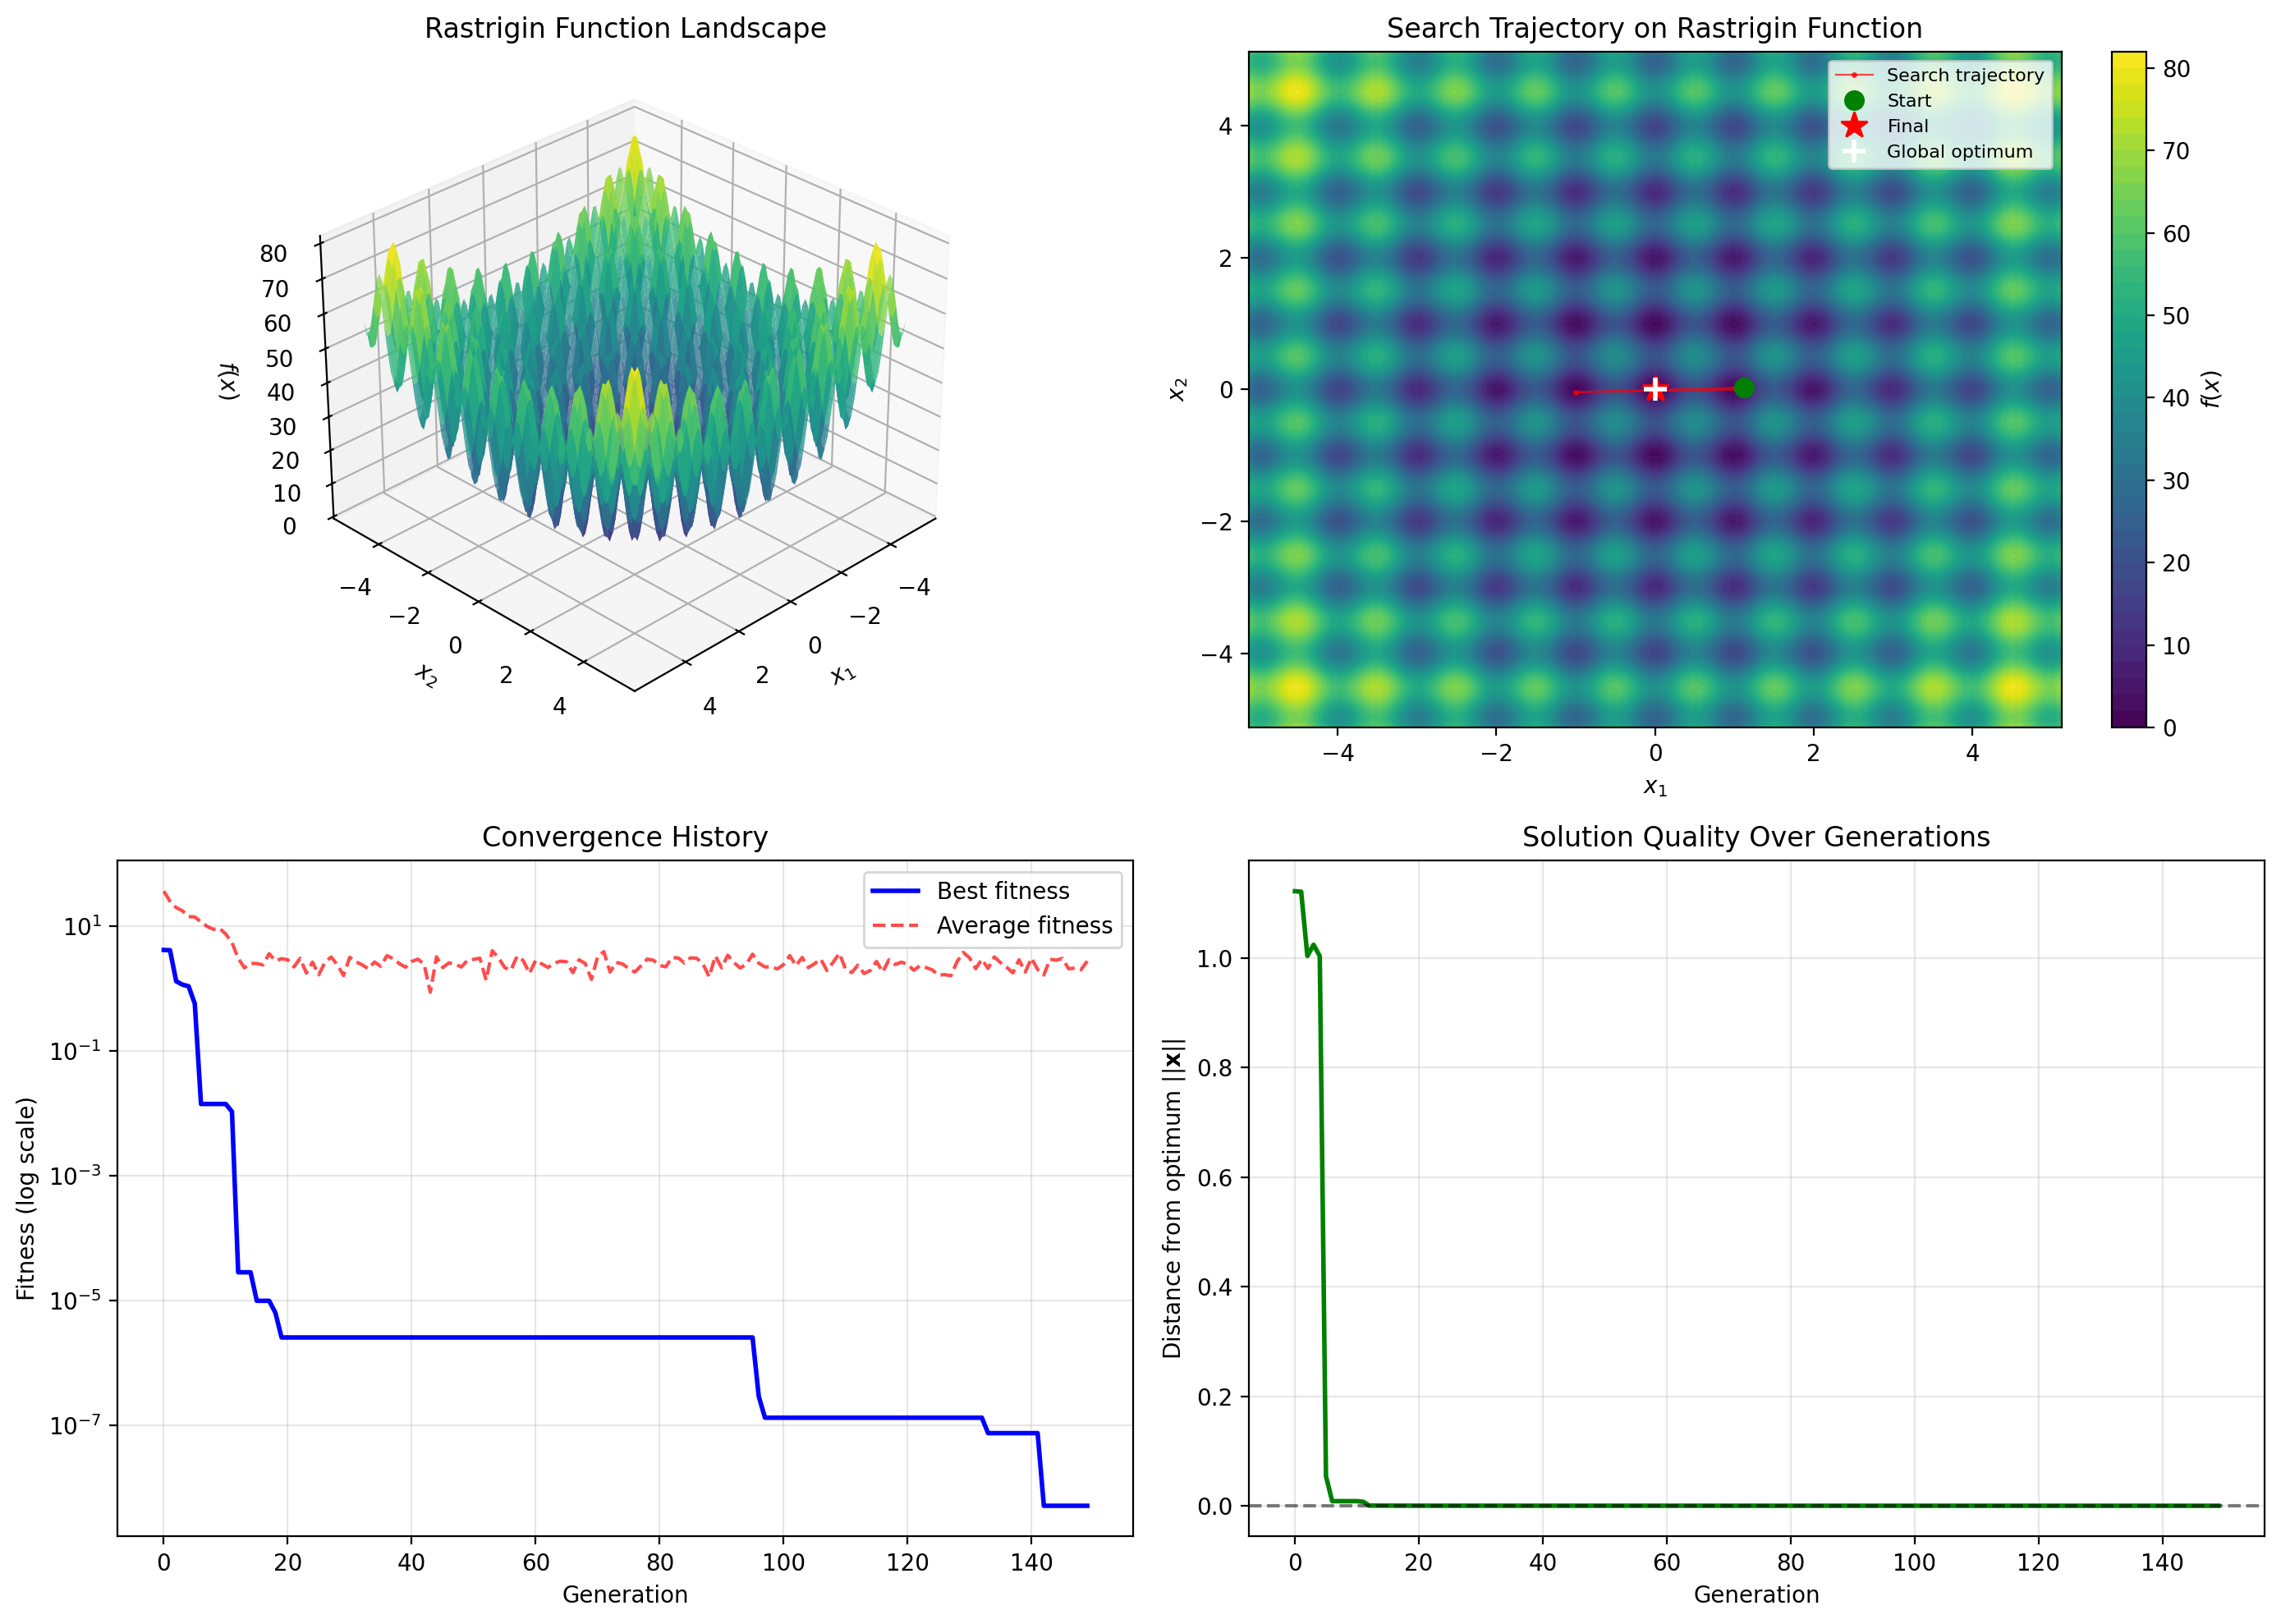


Figure saved to 'plot.png'


In [5]:
# Create figure with subplots
fig = plt.figure(figsize=(14, 10))

# Plot 1: 3D surface of Rastrigin function
ax1 = fig.add_subplot(221, projection='3d')
x = np.linspace(-5.12, 5.12, 100)
y = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(x, y)
Z = 20 + X**2 - 10*np.cos(2*np.pi*X) + Y**2 - 10*np.cos(2*np.pi*Y)

surf = ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.8, 
                        linewidth=0, antialiased=True)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_zlabel('$f(x)$')
ax1.set_title('Rastrigin Function Landscape')
ax1.view_init(elev=30, azim=45)

# Plot 2: Contour plot with search trajectory
ax2 = fig.add_subplot(222)
contour = ax2.contourf(X, Y, Z, levels=50, cmap=cm.viridis)
plt.colorbar(contour, ax=ax2, label='$f(x)$')

# Plot trajectory of best solution
trajectory = np.array(ga.best_solution_history)
ax2.plot(trajectory[:, 0], trajectory[:, 1], 'r.-', markersize=3, 
         linewidth=0.8, alpha=0.7, label='Search trajectory')
ax2.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=8, label='Start')
ax2.plot(trajectory[-1, 0], trajectory[-1, 1], 'r*', markersize=12, label='Final')
ax2.plot(0, 0, 'w+', markersize=10, markeredgewidth=2, label='Global optimum')

ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('Search Trajectory on Rastrigin Function')
ax2.legend(loc='upper right', fontsize=8)

# Plot 3: Convergence history
ax3 = fig.add_subplot(223)
generations = np.arange(len(ga.best_fitness_history))
ax3.semilogy(generations, ga.best_fitness_history, 'b-', linewidth=2, label='Best fitness')
ax3.semilogy(generations, ga.avg_fitness_history, 'r--', linewidth=1.5, 
             alpha=0.7, label='Average fitness')
ax3.set_xlabel('Generation')
ax3.set_ylabel('Fitness (log scale)')
ax3.set_title('Convergence History')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Distance from optimum over generations
ax4 = fig.add_subplot(224)
distances = [np.linalg.norm(sol) for sol in ga.best_solution_history]
ax4.plot(generations, distances, 'g-', linewidth=2)
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Generation')
ax4.set_ylabel('Distance from optimum $||\mathbf{x}||$')
ax4.set_title('Solution Quality Over Generations')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('genetic_algorithm_optimization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Analysis and Discussion

### Observations

1. **Convergence Behavior**: The algorithm shows rapid initial improvement followed by gradual refinement. The semi-log plot reveals exponential-like convergence in early generations.

2. **Population Diversity**: The gap between best and average fitness indicates population diversity. A shrinking gap suggests convergence, while maintaining some gap prevents premature convergence.

3. **Local Optima**: The Rastrigin function has $\approx 10^n$ local minima. Despite this, the GA successfully navigates toward the global optimum through its stochastic search mechanisms.

### Parameter Sensitivity

- **Mutation rate**: Higher values maintain diversity but slow convergence; lower values risk premature convergence
- **Crossover rate**: Balances exploration (low) vs exploitation (high)
- **Tournament size**: Larger sizes increase selection pressure
- **Elitism**: Preserves good solutions but may reduce diversity

### Computational Complexity

Per generation: $O(N \cdot n \cdot k)$ where $N$ is population size, $n$ is dimensionality, and $k$ is tournament size.

Total: $O(G \cdot N \cdot n \cdot k)$ for $G$ generations.

### Extensions

- **Adaptive parameters**: Adjust mutation/crossover rates during evolution
- **Island models**: Parallel subpopulations with migration
- **Hybrid approaches**: Combine with local search (memetic algorithms)
- **Constraint handling**: Penalty functions or specialized operators

## Conclusion

This notebook demonstrated the implementation of a Genetic Algorithm for continuous optimization. Key takeaways:

1. GAs are effective for multimodal optimization problems where gradient methods fail
2. The balance between exploration and exploitation is crucial
3. Parameter tuning significantly affects performance
4. The stochastic nature provides robustness to local optima

The algorithm successfully optimized the challenging Rastrigin function, finding solutions very close to the global optimum despite the presence of numerous local minima.